In [92]:
import json
import requests
from pprint import pprint
import re
import string
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
import warnings
import sys
import torch

In [93]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cpu':
    raise RuntimeError("No GPU found")

print(f'Using device: {device}')

Using device: cuda


In [94]:
url = 'https://raw.githubusercontent.com/nmquang003/AI4E/main/10k_news.json'

response = requests.get(url)
if response.status_code == 200:
    try:
        data = response.json()

        if isinstance(data, list) and len(data) > 0:
            pprint(json.dumps(data[0], indent=4, ensure_ascii=False))
        else:
            print("Dữ liệu JSON không phải là một danh sách hoặc danh sách trống.")

    except json.JSONDecodeError as e:
        print("JSONDecodeError: Không thể phân tích nội dung JSON.")
        print("Nội dung phản hồi không phải là JSON hợp lệ:")
        print(response.text)
else:
    print(f"Yêu cầu thất bại với mã trạng thái {response.status_code}")
    print("Nội dung phản hồi:", response.text)

('{\n'
 '    "url": '
 '"https://vietnamnet.vn/dien-bien-to-chuc-hoi-nghi-tap-huan-cong-tac-nhan-quyen-nam-2023-2205811.html",\n'
 '    "title": "Điện Biên tổ chức Hội nghị tập huấn công tác nhân quyền năm '
 '2023",\n'
 '    "description": "Ngày 4/10, Ban Chỉ đạo Nhân quyền tỉnh Điện Biên phối '
 'hợp với Văn phòng Thường trực về Nhân quyền của Chính phủ tổ chức Hội nghị '
 'tập huấn công tác Nhân quyền trên địa bàn tỉnh năm 2023.",\n'
 '    "content": "Tại Hội nghị, các đại biểu đã được các báo cáo viên của Văn '
 'phòng Thường trực về nhân quyền, Ban Tôn giáo Trung ương trình bày các '
 'chuyên đề: “Công tác nhân quyền trong tình hình mới...”; “Đảm bảo quyền tự '
 'do tín ngường, tôn giáo...”.\\nCác báo cáo viên đã cung cấp nhiều thông tin '
 'mới về hoạt động lợi dụng dân tộc, tôn giáo, dân chủ, nhân quyền chống phá '
 'Việt Nam; thông tin về quyền con người và các quan điểm, chủ trương, chính '
 'sách bảo đảm quyền con người của Đảng, Nhà nước ta. Đồng thời, chia sẻ kinh '
 'nghiệ

In [95]:
categories = [article['metadata']['cat'] for article in data]

category_counts = {}
for category in categories:
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1

for category, count in category_counts.items():
    print(f"Category: {category}, Count: {count}")

Category: DÂN TỘC - TÔN GIÁO, Count: 164
Category: AN SINH, Count: 198
Category: TUẦN VIỆT NAM, Count: 203
Category: Ô TÔ - XE MÁY, Count: 383
Category: GIẢI TRÍ, Count: 399
Category: Xe, Count: 174
Category: NỘI DUNG CHUYÊN ĐỀ, Count: 184
Category: KHOA HỌC - CÔNG NGHỆ, Count: 177
Category: Pháp luật, Count: 211
Category: Đời sống, Count: 173
Category: PHÁP LUẬT, Count: 396
Category: DU LỊCH, Count: 395
Category: THÔNG TIN VÀ TRUYỀN THÔNG, Count: 181
Category: SỨC MẠNH SỐ, Count: 175
Category: Giải trí, Count: 208
Category: CHÍNH TRỊ, Count: 203
Category: BẠN ĐỌC, Count: 204
Category: LAO ĐỘNG - VIỆC LÀM, Count: 203
Category: KINH DOANH, Count: 510
Category: Bất động sản, Count: 200
Category: DÂN TỘC THIỂU SỐ VÀ MIỀN NÚI, Count: 182
Category: Du lịch, Count: 194
Category: SỨC KHỎE, Count: 406
Category: ĐỜI SỐNG, Count: 357
Category: Khoa học, Count: 177
Category: BẤT ĐỘNG SẢN, Count: 372
Category: THẾ GIỚI, Count: 367
Category: Kinh doanh, Count: 201
Category: Thế giới, Count: 201
Cat

Filtered articles count: 7853


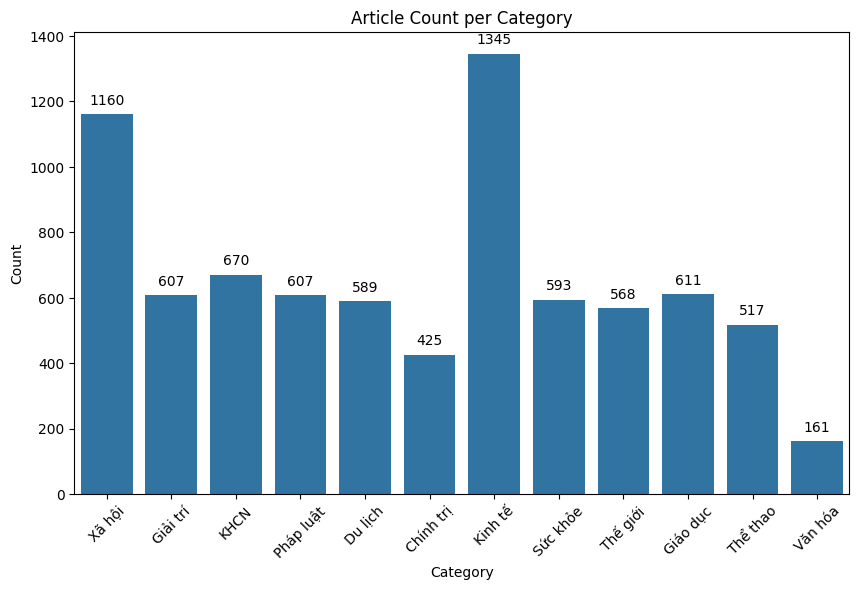

In [96]:
category_mapping = {
    "CHÍNH TRỊ": "Chính trị",
    "THỜI SỰ": "Chính trị",
    "XÃ HỘI": "Xã hội",
    "ĐỜI SỐNG": "Xã hội",
    "AN SINH": "Xã hội",
    "LAO ĐỘNG - VIỆC LÀM": "Xã hội",
    "TÌNH YÊU - GIỚI TÍNH": "Xã hội",
    "KHOA HỌC - CÔNG NGHỆ": "KHCN",
    "SỨC MẠNH SỐ": "KHCN",
    "Số hóa": "KHCN",
    "CÔNG NGHIỆP HỖ TRỢ": "KHCN",
    "KINH DOANH": "Kinh tế",
    "Kinh doanh": "Kinh tế",
    "THỊ TRƯỜNG - TIÊU DÙNG": "Kinh tế",
    "BẤT ĐỘNG SẢN": "Kinh tế",
    "Bất động sản": "Kinh tế",
    "THẾ GIỚI": "Thế giới",
    "Thế giới": "Thế giới",
    "VĂN HÓA": "Văn hóa",
    "GIẢI TRÍ": "Giải trí",
    "Giải trí": "Giải trí",
    "DU LỊCH": "Du lịch",
    "Du lịch": "Du lịch",
    "GIÁO DỤC": "Giáo dục",
    "Giáo dục": "Giáo dục",
    "SỨC KHỎE": "Sức khỏe",
    "Sức khỏe": "Sức khỏe",
    "Các bệnh": "Sức khỏe",
    "PHÁP LUẬT": "Pháp luật",
    "Pháp luật": "Pháp luật",
    "THỂ THAO": "Thể thao",
    "Thể thao": "Thể thao"
}

filtered_data = []
for article in data:
    old_category = article['metadata']['cat']
    if old_category in category_mapping:
        new_category = category_mapping[old_category]
        article['metadata']['cat'] = new_category
        filtered_data.append(article)

print(f"Filtered articles count: {len(filtered_data)}")

categories = [article['metadata']['cat'] for article in filtered_data]

category_counts = {}
for category in categories:
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=list(category_counts.keys()), y=list(category_counts.values()))
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Article Count per Category')
plt.xticks(rotation=45)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

Filtered articles to use count: 4096


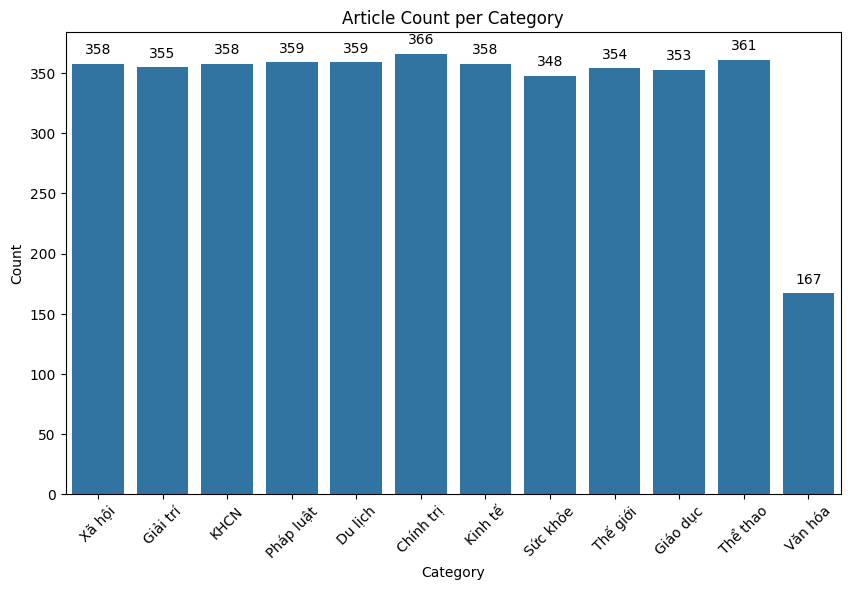

In [98]:
category_data = defaultdict(list)
for article in filtered_data:
    category_data[article['metadata']['cat']].append(article)

number_sample = 4096
max_samples_per_category = number_sample // len(category_data)

balanced_data = []
for category, items in category_data.items():
    if len(items) > max_samples_per_category:
        balanced_data.extend(random.sample(items, max_samples_per_category))
    else:
        balanced_data.extend(items)

if len(balanced_data) < number_sample:
    additional_samples = random.sample(balanced_data, number_sample - len(balanced_data))
    balanced_data.extend(additional_samples)

filtered_data_to_use = balanced_data[:number_sample if number_sample < len(balanced_data) else len(balanced_data)]
print(f"Filtered articles to use count: {len(filtered_data_to_use)}")

category_counts = defaultdict(int)
for item in filtered_data_to_use:
    category_counts[item['metadata']['cat']] += 1

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=list(category_counts.keys()), y=list(category_counts.values()))
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Article Count per Category')
plt.xticks(rotation=45)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

In [99]:
stop_words = set([
    "bị", "bởi", "cả", "các", "cái", "cần", "càng", "chỉ", "chiếc", "cho", "chứ", "chưa", "chuyện",
    "có", "có_thể", "cứ", "của", "cùng", "cũng", "đã", "đang", "đây", "để", "đến_nỗi", "đều", "điều",
    "do", "đó", "được", "dưới", "gì", "khi", "không", "là", "lại", "lên", "lúc", "mà", "mỗi", "này",
    "nên", "nếu", "ngay", "nhiều", "như", "nhưng", "những", "nơi", "nữa", "phải", "qua", "ra", "rằng",
    "rằng", "rất", "rồi", "sau", "sẽ", "so", "sự", "tại", "theo", "thì", "trên", "trước", "từ", "từng",
    "và", "vẫn", "vào", "vậy", "vì", "việc", "với", "vừa"
])

texts = []
labels = []

for article in filtered_data_to_use:
    text = article.get('title', '') + ' ' + article.get('content', '')
    label = article['metadata']['cat']
    texts.append(text)
    labels.append(label)

def preprocess_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = text.split()
    total_tokens = len(tokens)
    tokens = [token for token in tokens if token not in stop_words]
    removed_stop_words_percent = (total_tokens - len(tokens)) / total_tokens * 100
    return ' '.join(tokens), removed_stop_words_percent

processed_texts = []
sum_stop_words_percents = 0

tqdm_iter = tqdm(texts, desc="Processing texts")

for i, text in enumerate(tqdm_iter):
    processed_text, stop_words_percent = preprocess_text(text)
    processed_texts.append(processed_text)
    sum_stop_words_percents += stop_words_percent
    avg_stop_words_percent = sum_stop_words_percents / (i+1)
    tqdm_iter.set_postfix({"avg_stop_words_percent": f"{avg_stop_words_percent:.2f}%"})

texts = processed_texts
average_stop_words_percent = sum_stop_words_percents / len(texts)
print(f"Average percentage of stop words removed: {average_stop_words_percent:.2f}%")

Processing texts:   0%|          | 0/4096 [00:00<?, ?it/s]

Average percentage of stop words removed: 18.68%


In [100]:
print("Văn bản sau sử lý: ", texts[0])
print("Nhãn của văn bản: ", labels[0])

Văn bản sau sử lý:  doanh nghiệp tăng lương công nhân tết thay chờ đến 17 công đoàn khu kinh tế hải phòng 105 doanh nghiệp địa bàn chủ động tăng lương công nhân lao động 11 thay chờ đến ngày 17 thời điểm dự kiến chỉnh lương tối thiểu vùng đơn cử công ty tnhh synztec việt nam khu công nghiệp nhật bản hải phòng thông báo ngày 11 tăng lương người lao động mức 270000 đồngngườitháng đến nay thu nhập trung bình gần 1000 lao động công ty hơn 8 triệu đồngngườitháng bên cạnh thống kê công đoàn khu kinh tế hải phòng thấy doanh nghiệp tăng lương công nhân trực tiếp ở mức cao công ty tnhh lihitlab việt nam khu công nghiệp nhật bản hải phòng tăng 550000 đồngngườitháng công ty tnhh rrc khu công nghiệp nam đình vũ công ty shinec công ty meihotech tăng ở mức 500000 đồngngườitháng doanh nghiệp chỉnh tiền lương người lao động ngày 11 ảnh minh họa văn quang sở lao động thương binh xã hội hải phòng tiền lương bình quân người lao động doanh nghiệp địa bàn năm 2023 cao hơn lương tối thiểu vùng đạt mức bình 

In [109]:
y = np.array(labels)

texts_train, texts_test, y_train, y_test = train_test_split(texts, y, test_size=0.2, stratify=y, random_state=42)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

print("Nhãn gốc: ", y_train[:5])
print("Nhãn sau khi mã hóa: ", y_train_enc[:5])

texts_train, y_train_enc = shuffle(texts_train, y_train_enc, random_state=42)

tfidf_vectorizer = TfidfVectorizer(max_features=5000, tokenizer=lambda x: x, preprocessor=lambda x: x, token_pattern=None)
X_train_tfidf = tfidf_vectorizer.fit_transform(texts_train)
X_test_tfidf = tfidf_vectorizer.transform(texts_test)

print("Kích thức của tập train: ", X_train_tfidf.shape)

Nhãn gốc:  ['KHCN' 'Xã hội' 'Xã hội' 'Chính trị' 'KHCN']
Nhãn sau khi mã hóa:  [ 4 11 11  0  4]
Kích thức của tập train:  (3276, 147)


In [110]:
nb_model = MultinomialNB(alpha=1.0)

nb_model.fit(X_train_tfidf, y_train_enc)

y_pred_enc_nb = nb_model.predict(X_test_tfidf)
y_pred_nb = le.inverse_transform(y_pred_enc_nb)

report_nb = classification_report(y_test, y_pred_nb, output_dict=True, zero_division=0)

In [111]:
lr_model = LogisticRegression(max_iter=1000)

lr_model.fit(X_train_tfidf, y_train_enc)

y_pred_enc_lr = lr_model.predict(X_test_tfidf)
y_pred_lr = le.inverse_transform(y_pred_enc_lr)

report_lr = classification_report(y_test, y_pred_lr, output_dict=True, zero_division=0)

In [112]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train_tfidf, y_train_enc)

y_pred_enc_rf = rf_model.predict(X_test_tfidf)
y_pred_rf = le.inverse_transform(y_pred_enc_rf)

report_rf = classification_report(y_test, y_pred_rf, output_dict=True, zero_division=0)

In [113]:
svc_model = SVC(kernel='linear', C=1)

svc_model.fit(X_train_tfidf, y_train_enc)

y_pred_enc_svc = svc_model.predict(X_test_tfidf)
y_pred_svc = le.inverse_transform(y_pred_enc_svc)

report_svc = classification_report(y_test, y_pred_svc, output_dict=True, zero_division=0)


Naive Bayes Metrics:
Chính trị: Precision=0.46, Recall=0.60, F1-Score=0.52
Du lịch: Precision=0.51, Recall=0.64, F1-Score=0.57
Giáo dục: Precision=0.93, Recall=0.52, F1-Score=0.67
Giải trí: Precision=0.70, Recall=0.44, F1-Score=0.54
KHCN: Precision=0.40, Recall=0.68, F1-Score=0.51
Kinh tế: Precision=0.67, Recall=0.36, F1-Score=0.47
Pháp luật: Precision=0.57, Recall=0.75, F1-Score=0.65
Sức khỏe: Precision=1.00, Recall=0.41, F1-Score=0.58
Thế giới: Precision=0.84, Recall=0.73, F1-Score=0.78
Thể thao: Precision=0.66, Recall=0.89, F1-Score=0.76
Văn hóa: Precision=0.00, Recall=0.00, F1-Score=0.00
Xã hội: Precision=0.30, Recall=0.44, F1-Score=0.36
Overall Accuracy: 0.56

Logistic Regression Metrics:
Chính trị: Precision=0.46, Recall=0.56, F1-Score=0.50
Du lịch: Precision=0.51, Recall=0.54, F1-Score=0.52
Giáo dục: Precision=0.63, Recall=0.80, F1-Score=0.70
Giải trí: Precision=0.53, Recall=0.48, F1-Score=0.50
KHCN: Precision=0.42, Recall=0.38, F1-Score=0.40
Kinh tế: Precision=0.56, Recall=0.3

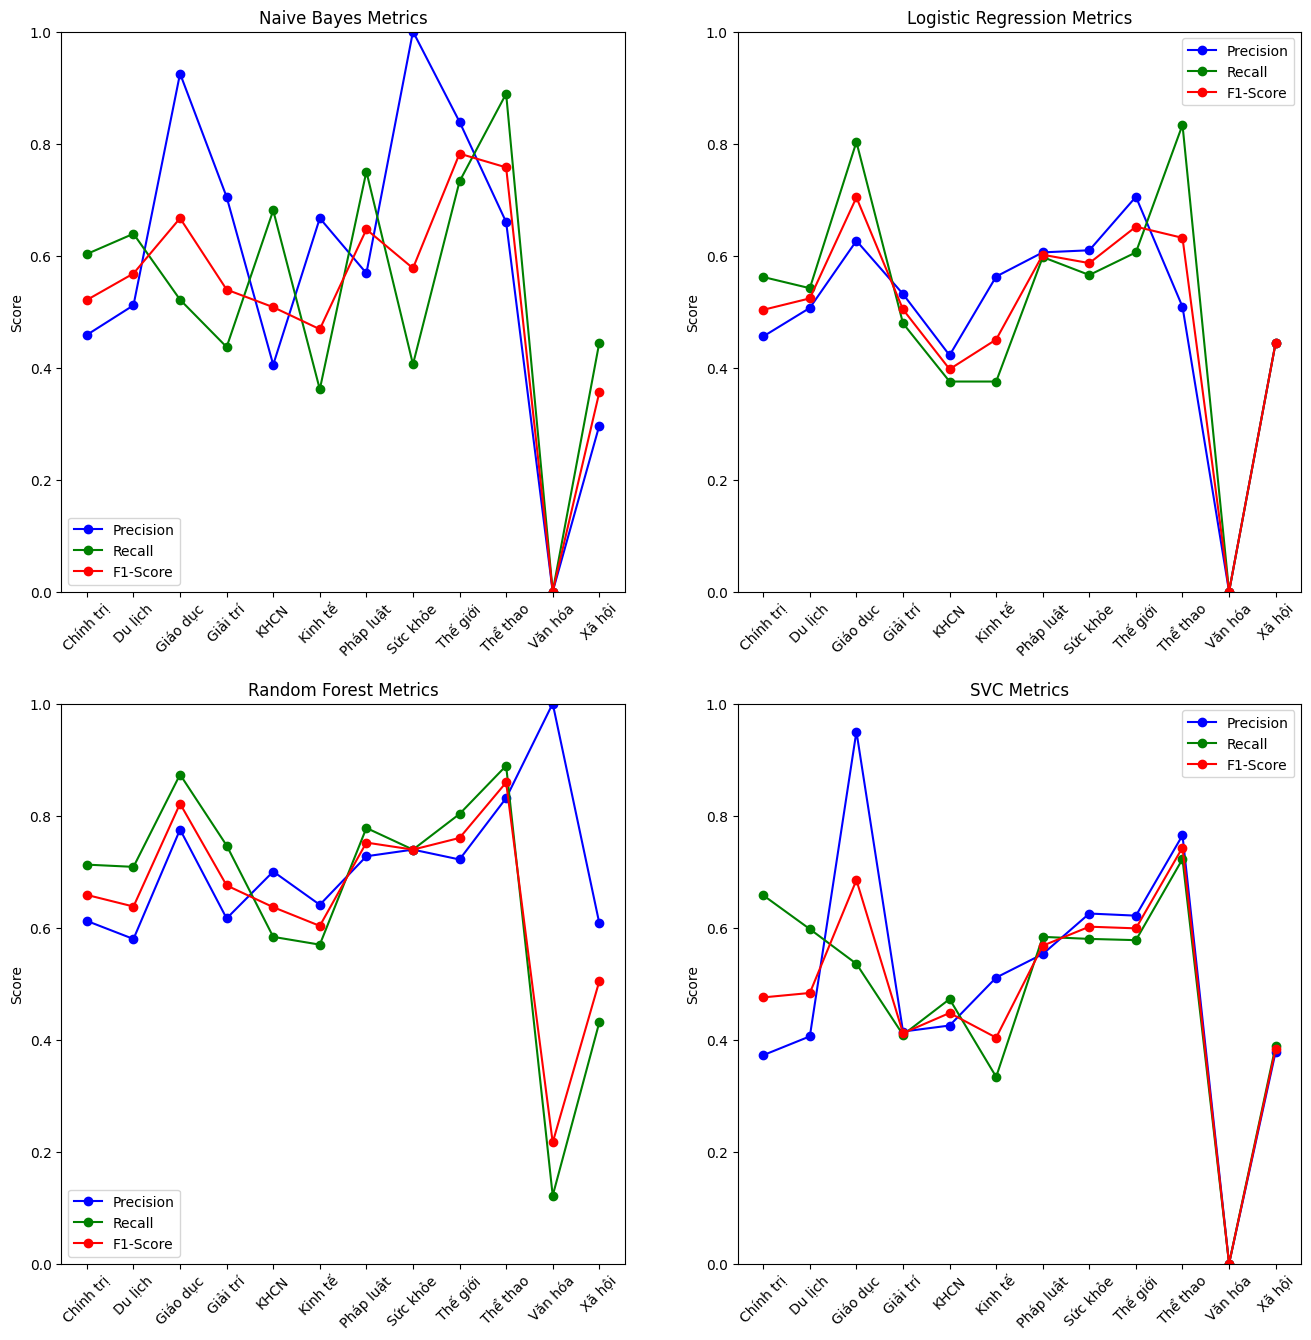

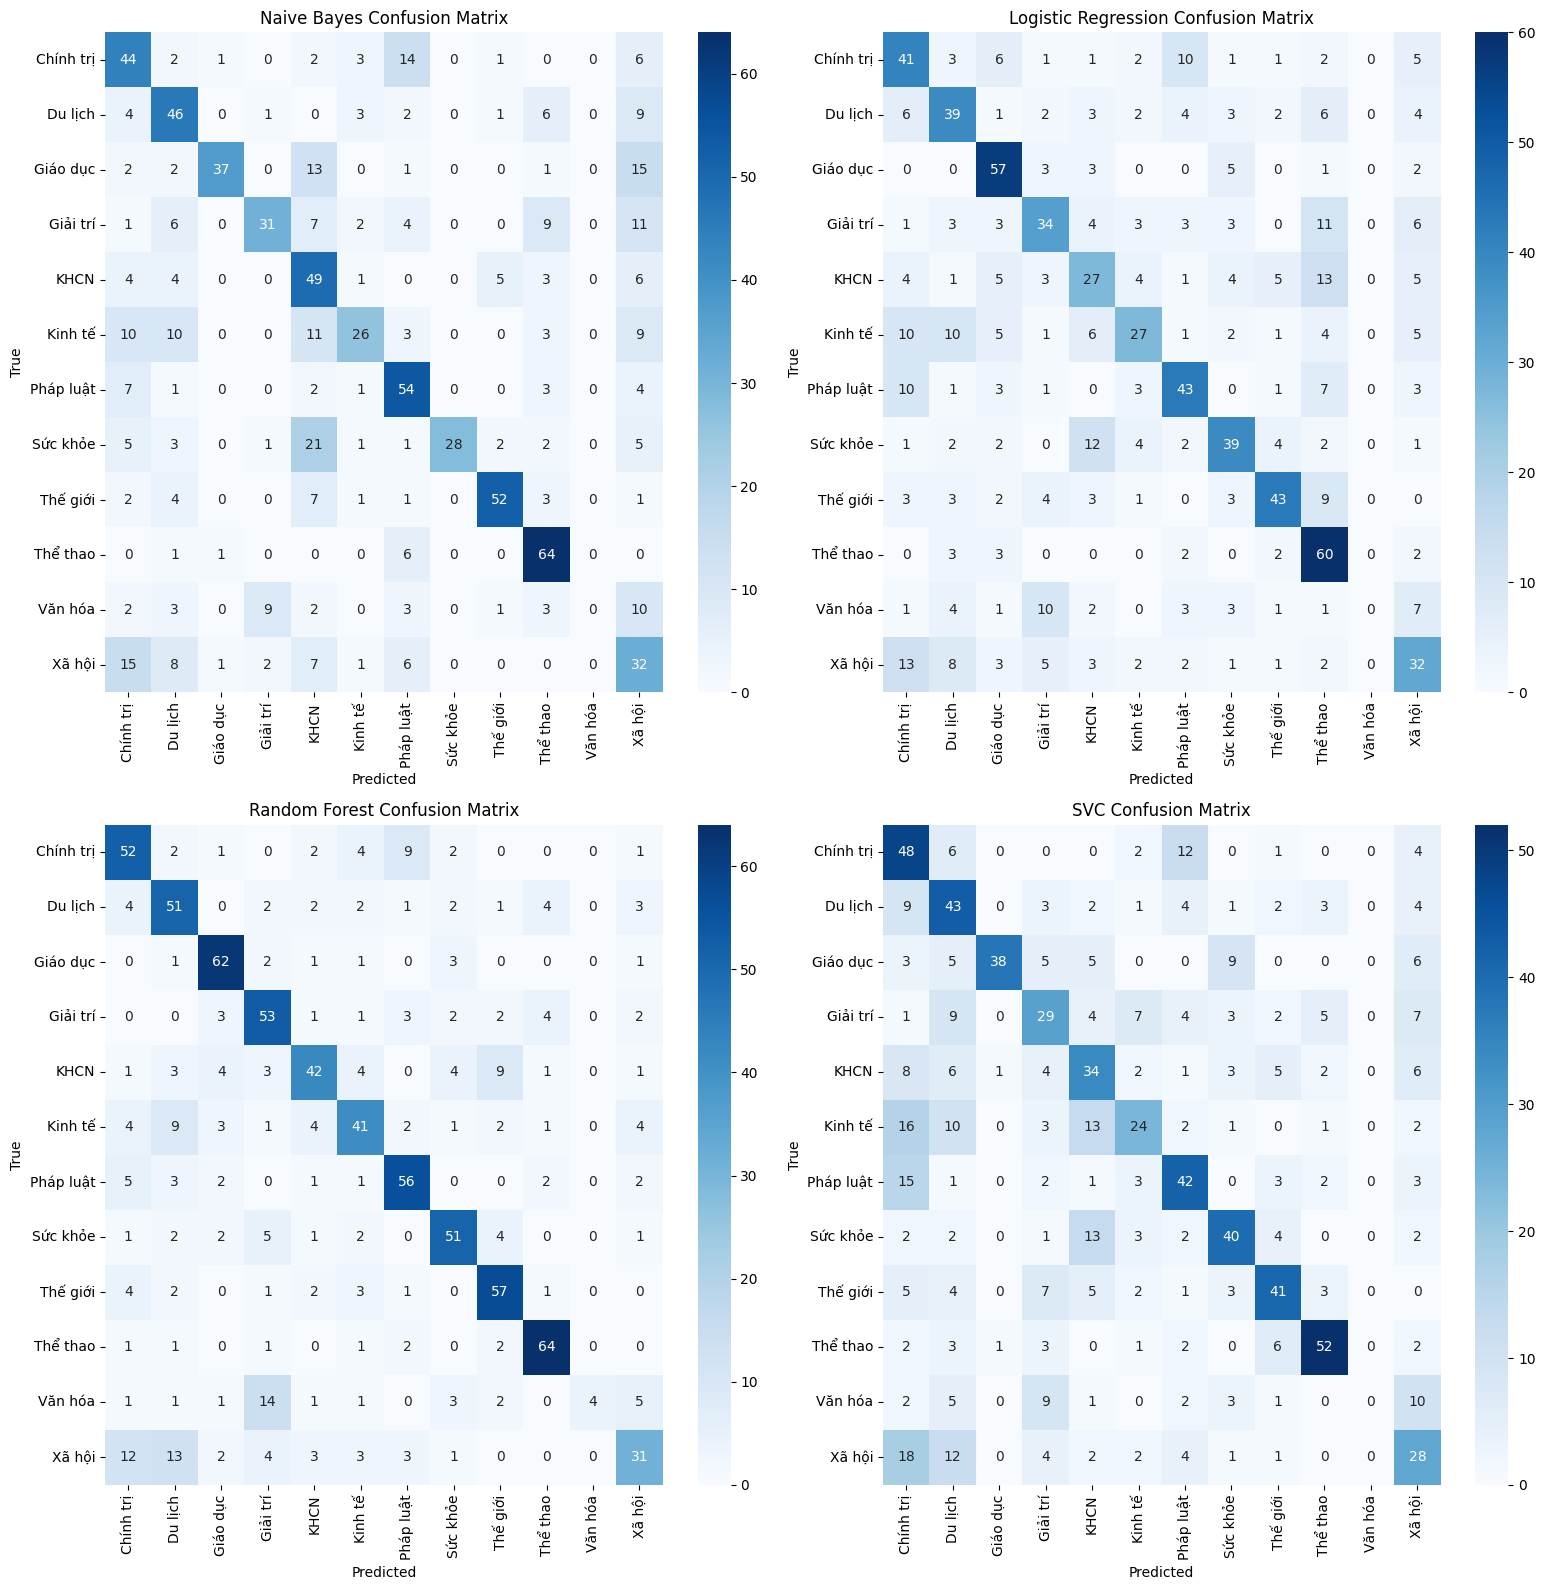

In [114]:
reports = {
    'Naive Bayes': report_nb,
    'Logistic Regression': report_lr,
    'Random Forest': report_rf,
    'SVC': report_svc
}

fig, axs = plt.subplots(2, 2, figsize=(16, 16))
fig_cm, axs_cm = plt.subplots(2, 2, figsize=(16, 16))

for i, (name, report) in enumerate(reports.items()):
    categories = list(report.keys())[:-3]
    precisions = [report[cat]['precision'] for cat in categories]
    recalls = [report[cat]['recall'] for cat in categories]
    f1_scores = [report[cat]['f1-score'] for cat in categories]

    print(f'\n{name} Metrics:')
    for category in categories:
        print(f"{category}: Precision={report[category]['precision']:.2f}, Recall={report[category]['recall']:.2f}, F1-Score={report[category]['f1-score']:.2f}")

    accuracy = report['accuracy']
    print(f'Overall Accuracy: {accuracy:.2f}')

    axs[i // 2, i % 2].plot(categories, precisions, marker='o', label='Precision', color='blue')
    axs[i // 2, i % 2].plot(categories, recalls, marker='o', label='Recall', color='green')
    axs[i // 2, i % 2].plot(categories, f1_scores, marker='o', label='F1-Score', color='red')
    axs[i // 2, i % 2].set_ylim(0, 1)
    axs[i // 2, i % 2].set_title(f'{name} Metrics')
    axs[i // 2, i % 2].set_ylabel('Score')
    axs[i // 2, i % 2].legend()
    axs[i // 2, i % 2].tick_params(axis='x', rotation=45)

    if name == 'Naive Bayes':
        cm = confusion_matrix(y_test, y_pred_nb, labels=le.classes_)
    elif name == 'Logistic Regression':
        cm = confusion_matrix(y_test, y_pred_lr, labels=le.classes_)
    elif name == 'Random Forest':
        cm = confusion_matrix(y_test, y_pred_rf, labels=le.classes_)
    elif name == 'SVC':
        cm = confusion_matrix(y_test, y_pred_svc, labels=le.classes_)

    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues', ax=axs_cm[i // 2, i % 2])
    axs_cm[i // 2, i % 2].set_title(f'{name} Confusion Matrix')
    axs_cm[i // 2, i % 2].set_xlabel('Predicted')
    axs_cm[i // 2, i % 2].set_ylabel('True')

plt.tight_layout()
plt.show()

In [64]:
print("Nội dung bài báo: ", texts_train[0])
print("Nhãn dự đoán:" , le.inverse_transform(rf_model.predict(X_test_tfidf[:1])))
print("Nhãn thực tế: ", le.inverse_transform(y_train_enc[:1]))

Nội dung bài báo:  lê giang cây hài chuyên đóng phim trăm tỷ đầu tháng 7 gặp chị bầu phim lê giang đóng vai phụ̣ một chủ nhà trọ đùm bọc nhóm bạn trẻ thập niên 1990 vượt 100 tỷ đồng tính thị trường nước ngoài tác phẩm giúp lê giang trở thành nữ diễn viên góp mặt trong phim trăm tỷ đồng nhất hiện nay năm phim sắc vóc tuổi 52 lê giang ảnh nhân vật cung cấp gây chú ý ở màn ảnh rộng lê giang cây hài sân khấu quen thuộc năm 1990 chị gia nhập đoàn cải lương thanh nga giành huy chương vàng hội diễn sân khấu chuyên nghiệp vở dòng sông đầm lầy thập niên 2000 chị dần chuyển sang diễn hài đoạt giải nghệ sĩ triển vọng ở gala cười 2005 thanh nhân viên văn phòng trong phim cô gái xấu xí 2008 vai hiếm hoi chị ghi dấu màn ảnh nhỏ năm 2019 lê giang góp mặt trong cua vợ bầu đạo diễn nhất trung vai phụ mẹ nữ chính nhã linh lan ngọc diễn viên gây cười một số phân cảnh đóng cặp nghệ sĩ hữu châu dù ít đất diễn tên tuổi chị chú ý hơn phim bất ngờ thành công mùa tết năm doanh thu đạt hơn 190 tỷ đồng bước ngoặ

In [65]:
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained('vinai/phobert-base')
embeder = AutoModel.from_pretrained('vinai/phobert-base')

embeder.to(device)

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(64001, 768, padding_idx=1)
    (position_embeddings): Embedding(258, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

In [66]:
def encode_texts(texts, tokenizer, embeder, max_length=256):
    encoded_texts = []

    for text in tqdm(texts, desc="Chuyển từ thành vector"):
        inputs = tokenizer(text, return_tensors="pt", max_length=max_length, truncation=True, padding="max_length").to(device)

        with torch.no_grad():
            outputs = embeder(**inputs)

        encoded_texts.append(outputs.last_hidden_state.squeeze(0))

    return torch.stack(encoded_texts)

In [67]:
test = ["Xin chào", "Đây là chương trình AI4E"]
encode_texts(test, tokenizer, embeder).shape

Chuyển từ thành vector:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([2, 256, 768])

In [68]:
X_train_phobert = encode_texts(texts_train, tokenizer, embeder)
X_test_phobert = encode_texts(texts_test, tokenizer, embeder)

Chuyển từ thành vector:   0%|          | 0/3276 [00:00<?, ?it/s]

Chuyển từ thành vector:   0%|          | 0/820 [00:00<?, ?it/s]

In [69]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

train_dataset = TextDataset(X_train_phobert, y_train_enc)
test_dataset = TextDataset(X_test_phobert, y_test_enc)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [70]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNNClassifier, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

class CNNClassifier(nn.Module):
    def __init__(self, input_size, output_size, num_filters, kernel_size, max_length=256):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=num_filters, kernel_size=kernel_size)
        self.pool = nn.MaxPool1d(kernel_size=max_length - kernel_size + 1)
        self.fc = nn.Linear(num_filters, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.pool(x).squeeze(2)
        x = self.fc(x)
        return x

In [71]:
input_size = 768
output_size = len(le.classes_)

hidden_size = 128
num_filters = 128
kernel_size = 3

In [72]:
deep_models = {
    'RNN': RNNClassifier(input_size, hidden_size, output_size, num_layers=1).to(device),
    'LSTM': LSTMClassifier(input_size, hidden_size, output_size, num_layers=1).to(device),
    'CNN': CNNClassifier(input_size, output_size, num_filters, kernel_size, max_length=256).to(device)
}

In [73]:
def train_and_evaluate(model, train_loader, test_loader, num_epochs=10, criterion=None, optimizer_fn=None, scheduler_fn=None):
    optimizer = optimizer_fn(model.parameters())

    scheduler = scheduler_fn(optimizer)

    for epoch in range(num_epochs):
        model.train()
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if scheduler is not None:
            scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

In [74]:
criterion = nn.CrossEntropyLoss()

def optimizer_fn(params):
    return torch.optim.Adam(params, lr=0.001)

def scheduler_fn(optimizer):
    return torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

num_epochs = 10

Training RNN model...
Epoch [1/10], Loss: 1.0362
Epoch [2/10], Loss: 0.7998
Epoch [3/10], Loss: 0.9157
Epoch [4/10], Loss: 0.2749
Epoch [5/10], Loss: 0.3987
Epoch [6/10], Loss: 0.1555
Epoch [7/10], Loss: 0.1766
Epoch [8/10], Loss: 0.0768
Epoch [9/10], Loss: 0.0610
Epoch [10/10], Loss: 0.0571

RNN Metrics:
Chính trị: Precision=0.62, Recall=0.72, F1-Score=0.67
Du lịch: Precision=0.74, Recall=0.79, F1-Score=0.77
Giáo dục: Precision=0.89, Recall=0.93, F1-Score=0.91
Giải trí: Precision=0.76, Recall=0.66, F1-Score=0.71
KHCN: Precision=0.76, Recall=0.81, F1-Score=0.78
Kinh tế: Precision=0.73, Recall=0.68, F1-Score=0.70
Pháp luật: Precision=0.91, Recall=0.79, F1-Score=0.85
Sức khỏe: Precision=0.89, Recall=0.94, F1-Score=0.92
Thế giới: Precision=0.79, Recall=0.83, F1-Score=0.81
Thể thao: Precision=0.93, Recall=0.94, F1-Score=0.94
Văn hóa: Precision=0.53, Recall=0.53, F1-Score=0.53
Xã hội: Precision=0.54, Recall=0.46, F1-Score=0.50
Overall Accuracy: 0.77

Training LSTM model...
Epoch [1/10], Los

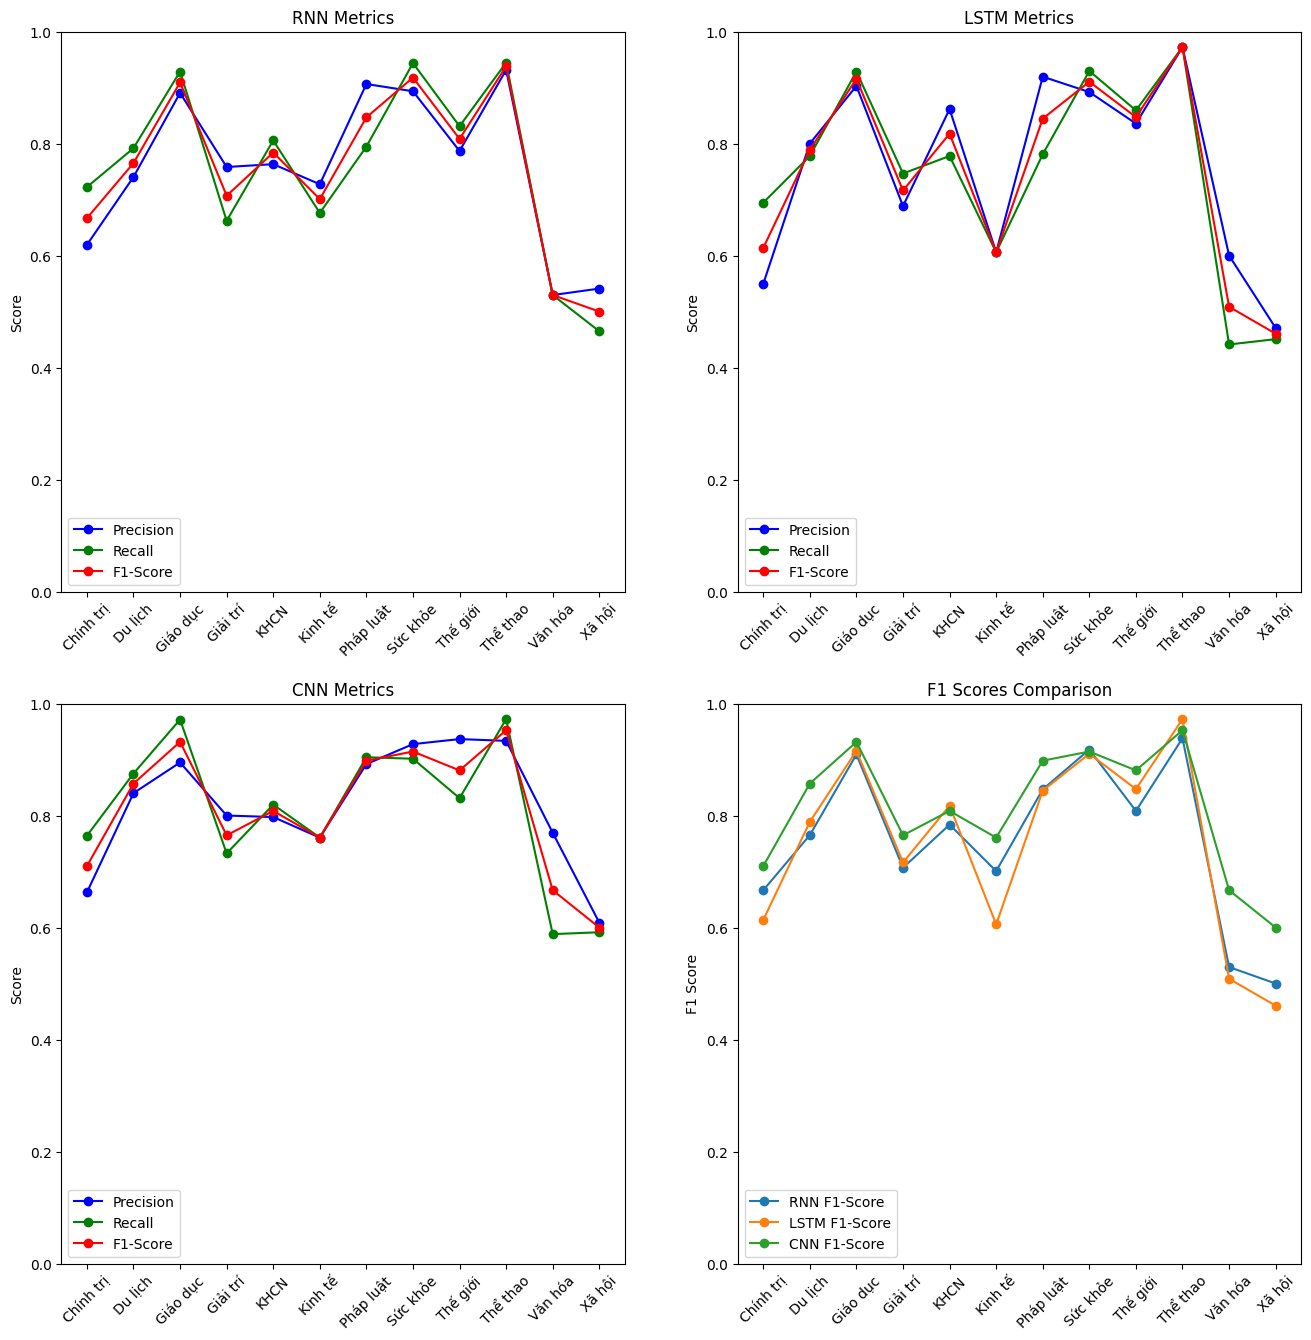

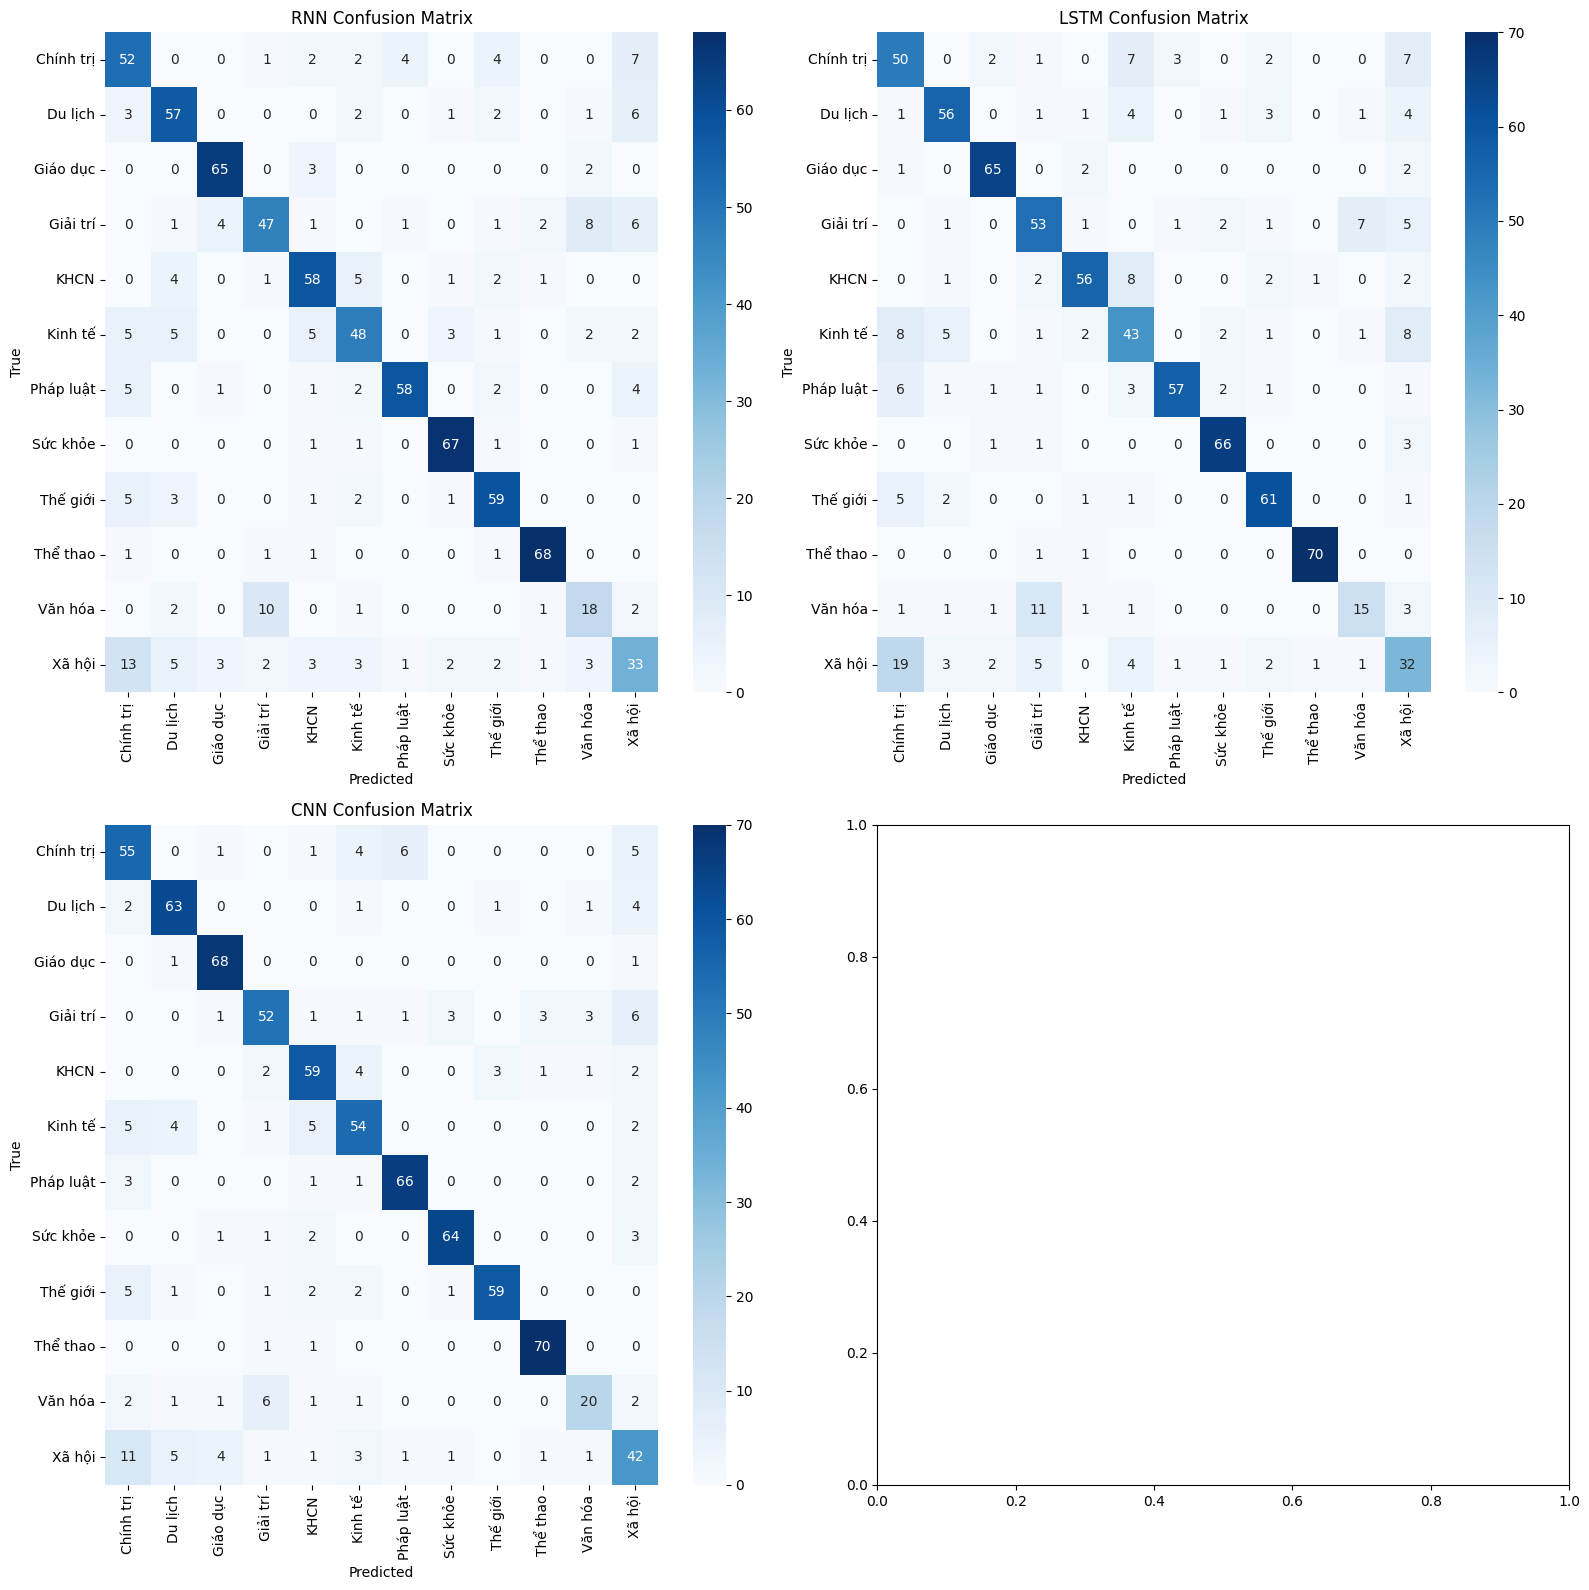

In [75]:
fig, axs = plt.subplots(2, 2, figsize=(16, 16))
fig_cm, axs_cm = plt.subplots(2, 2, figsize=(16, 16))

model_f1_scores = {}

for i, (name, model) in enumerate(deep_models.items()):
    print(f"Training {name} model...")
    y_test, y_pred = train_and_evaluate(model, train_loader, test_loader, num_epochs=10,
                                        criterion=criterion, optimizer_fn=optimizer_fn, scheduler_fn=scheduler_fn)
    y_test = le.inverse_transform(y_test)
    y_pred = le.inverse_transform(y_pred)

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    categories = list(report.keys())[:-3]
    precisions = [report[cat]['precision'] for cat in categories]
    recalls = [report[cat]['recall'] for cat in categories]
    f1_scores = [report[cat]['f1-score'] for cat in categories]
    model_f1_scores[name] = f1_scores

    print(f'\n{name} Metrics:')
    for category in categories:
        print(f"{category}: Precision={report[category]['precision']:.2f}, Recall={report[category]['recall']:.2f}, F1-Score={report[category]['f1-score']:.2f}")

    accuracy = report['accuracy']
    print(f'Overall Accuracy: {accuracy:.2f}\n')

    axs[i // 2, i % 2].plot(categories, precisions, marker='o', label='Precision', color='blue')
    axs[i // 2, i % 2].plot(categories, recalls, marker='o', label='Recall', color='green')
    axs[i // 2, i % 2].plot(categories, f1_scores, marker='o', label='F1-Score', color='red')
    axs[i // 2, i % 2].set_ylim(0, 1)
    axs[i // 2, i % 2].set_title(f'{name} Metrics')
    axs[i // 2, i % 2].set_ylabel('Score')
    axs[i // 2, i % 2].legend()
    axs[i // 2, i % 2].tick_params(axis='x', rotation=45)

    cm = confusion_matrix(y_test, y_pred, labels=le.classes_)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues', ax=axs_cm[i // 2, i % 2])
    axs_cm[i // 2, i % 2].set_title(f'{name} Confusion Matrix')
    axs_cm[i // 2, i % 2].set_xlabel('Predicted')
    axs_cm[i // 2, i % 2].set_ylabel('True')

for name, f1_scores in model_f1_scores.items():
    axs[1, 1].plot(categories, f1_scores, marker='o', label=f'{name} F1-Score')
axs[1, 1].set_ylim(0, 1)
axs[1, 1].set_title('F1 Scores Comparison')
axs[1, 1].set_ylabel('F1 Score')
axs[1, 1].legend()
axs[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [78]:
print("Văn bản đầu vào: ", texts_test[0])
print("Nhãn dự đoán: ", y_pred[0])
print("Nhãn thực tế: ", y_test[0])

Văn bản đầu vào:  sắp diễn triển lãm du học trực tuyến toàn quốc 2024 triển lãm du học trực tuyến lớn nhất toàn quốc 2024 ảnh intergreat cục hợp tác quốc tế bộ giáo dục đào tạo thống kê khoảng 190000 du học sinh việt học tập nghiên cứu ở nước ngoài trong năm học 20192020 học sinh việt nam tìm hiểu cơ hội du học tuy nhiên ai thời gian chi phí di chuyển tới thành phố lớn hà nội tphcm đà nẵng tham gia buổi triển lãm du học offline thông thường triển lãm du học online xuất hiện một xu thế tất yếu phá vỡ rào cản về khoảng cách địa lý triển lãm du học trực tuyến lớn nhất toàn quốc 2023 ảnh intergreat hiện intergreat số ít đơn vị tổ chức thành công triển lãm du học trực tuyến việt nam trong năm 2023 tới hơn 2000 phụ huynh học sinh tham gia kiện học sinh thông triển lãm hỗ trợ intergreat du học thành công tới quốc gia anh úc mỹ canada hàn quốc tiếp nối thành công ấy triển lãm du học trực tuyến toàn quốc 2024 intergreat tổ chức tham gia hội đồng anh british council tổ chức 14h 17h30 chiều chủ n

In [88]:
no_cat_url = 'https://raw.githubusercontent.com/nmquang003/AI4E/main/test_news_no_cat.json'
cat_url = 'https://raw.githubusercontent.com/nmquang003/AI4E/main/categories.txt'

response = requests.get(no_cat_url)
no_cat_data = json.loads(response.text)

In [89]:
processed_no_cat_texts = []
for item in no_cat_data:
    text = item.get('title', '') + ' ' + item.get('content', '')
    processed_text, _ = preprocess_text(text)
    processed_no_cat_texts.append(processed_text)

X_no_cat_tfidf = tfidf_vectorizer.transform(processed_no_cat_texts)

In [90]:
predictions = {}
for model_name in ['Naive Bayes', 'Logistic Regression', 'Random Forest', 'SVC']:
    if model_name == 'Naive Bayes':
        y_pred_enc = nb_model.predict(X_no_cat_tfidf)
    elif model_name == 'Logistic Regression':
        y_pred_enc = lr_model.predict(X_no_cat_tfidf)
    elif model_name == 'Random Forest':
        y_pred_enc = rf_model.predict(X_no_cat_tfidf)
    elif model_name == 'SVC':
        y_pred_enc = svc_model.predict(X_no_cat_tfidf)

    y_pred = le.inverse_transform(y_pred_enc)
    predictions[model_name] = y_pred.tolist()

for i, item in enumerate(no_cat_data):
    item['predictions'] = {model_name: preds[i] for model_name, preds in predictions.items()}

In [91]:
with open('predictions.json', 'w') as f:
    json.dump(no_cat_data, f, ensure_ascii=False, indent=4)

# Văn hóa và Xã hội không đủ tốt